In [2]:
import numpy as np
import pandas as pd
import os
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import cv2
import glob as gb
import tqdm
import time
import random

In [3]:
# set seed
np.random.seed(0)

In [4]:
# Define paths for training, testing, and prediction data

data_dir = './melanoma_cancer_dataset'
train_data = data_dir + '/train'
test_data = data_dir + '/test'

In [5]:
# Function to load images and labels
def load_data(data_path, max_images=None):
    images = []
    labels = []
    class_ = {'benign': 0, 'malignant': 1}
    for folder in os.listdir(data_path):
        data = gb.glob(pathname=data_path + "/" + folder + '/*.jpg')
        # Initialize a counter to keep track of how many images have been loaded
        counter = 0
        for img_path in data:
            img = cv2.imread(img_path)
            
            # Resize image
            img_resized = cv2.resize(img, (100, 100))
            
            # Random horizontal flip
            if random.random() > 0.5:  # 50% chance
                img_resized = cv2.flip(img_resized, 1)
            
            # Random rotation
            angle = random.randint(-10, 10)
            rows, cols = img_resized.shape[:2]
            M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
            img_resized = cv2.warpAffine(img_resized, M, (cols, rows))
            
            images.append(img_resized)
            labels.append(class_[folder])
            counter += 1
            # If the counter reaches the max_images limit, break from the loop
            if max_images is not None and counter >= max_images:
                break
    return np.array(images), np.array(labels)


In [6]:
# Use scaler to flatten and normalize the data
scaler = StandardScaler()

In [9]:
cache_path = "./svm_cached_data"

In [10]:
# loading images and scaling data takes a while, so we will save the flattened data to a file
# define the file paths
saved_train_data = cache_path + "/X_train_full_scaled.npy"
saved_test_data = cache_path + "/X_test_scaled.npy"
saved_train_labels = cache_path + "/y_train_full.npy"
saved_test_labels = cache_path + "/y_test.npy"

if os.path.exists(saved_train_data) and os.path.exists(saved_test_data) \
and os.path.exists(saved_train_labels) and os.path.exists(saved_test_labels):
    X_train_full_scaled = np.load(saved_train_data)
    X_test_scaled = np.load(saved_test_data)
    y_train_full = np.load(saved_train_labels)
    y_test = np.load(saved_test_labels)
    
else:
    X_train_full, y_train_full = load_data(train_data)
    X_test, y_test = load_data(test_data)
    
    np.save(saved_train_labels, y_train_full)
    np.save(saved_test_labels, y_test)
    
    X_train_full_flat = X_train_full.reshape(X_train_full.shape[0], -1)
    X_test_flat = X_test.reshape(X_test.shape[0], -1)
    
    X_train_full_scaled = scaler.fit(X_train_full_flat).transform(X_train_full_flat)
    X_test_scaled = scaler.transform(X_test_flat)
    
    np.save(saved_train_data, X_train_full_scaled)
    np.save(saved_test_data, X_test_scaled)

In [11]:

# check the number of classes in the full dataset
print('Number of classes in the full dataset:', len(np.unique(y_train_full)))
# check the distribution of the classes
print('Class distribution in the full dataset:', np.bincount(y_train_full))

Number of classes in the full dataset: 2
Class distribution in the full dataset: [5000 4605]


**Applying PCA Dimension Reduction**

In [13]:
# Initialize PCA

# define the file paths
saved_pca = cache_path + "/pca.npy"


# check if there is a saved PCA model if there is load it
if os.path.exists(saved_pca):
    pca = np.load(saved_pca, allow_pickle=True).item()
    X_train_full_pca = pca.transform(X_train_full_scaled)
    X_test_pca = pca.transform(X_test_scaled)
    print('Loaded PCA model')
# if not create a new PCA model
else:
    # we can explain 95% of the variance with 66 components, see data-exploration.ipynb
    pca = PCA(n_components=66)
    X_train_full_pca = pca.fit_transform(X_train_full_scaled)
    X_test_pca = pca.transform(X_test_scaled)
    
    # save the pca model for later use in case we need to use it again
    np.save(saved_pca, pca)
    print('Created PCA model')

Loaded PCA model


In [ ]:
# check the shape of the data
print(X_train_full_pca.shape)
print(X_test_pca.shape)

print(y_train_full.shape)
print(y_test.shape)

(9605, 66)
(1000, 66)
(9605,)
(1000,)


In [ ]:
# take only a subset of random images for some quick initial training to what kernel to use
# and what hyperparameters to use
indices = np.random.choice(X_train_full_pca.shape[0], 500, replace=False)
X_train = X_train_full_pca[indices]
y_train = y_train_full[indices]

In [ ]:
# split the train data into train and validation
# no need to shuffle the data are already randomly selected
validation_split = 0.2

# Split the data into training and validation
split_index = int(len(X_train) * (1 - validation_split))
X_train, X_val = X_train[:split_index], X_train[split_index:]
y_train, y_val = y_train[:split_index], y_train[split_index:]

In [ ]:
print('Training data shape:', X_train.shape)
print('Validation data shape:', X_val.shape)
# check the number of classes
print('Number of classes:', len(np.unique(y_train)))


# check the distribution of the classes
print('Class distribution:', np.bincount(y_train))

Training data shape: (400, 66)
Validation data shape: (100, 66)
Number of classes: 2
Class distribution: [203 197]


In [ ]:
# Train SVM model
linear_svm = SVC(kernel='linear')
linear_svm.fit(X_train, y_train)


SVC(kernel='linear')

In [ ]:
# Predict on validation data
y_pred = linear_svm.predict(X_val)
# Evaluate the model
accuracy = accuracy_score(y_val, y_pred)
print('Validation Accuracy:', accuracy)
print(classification_report(y_val, y_pred))

Validation Accuracy: 0.78
              precision    recall  f1-score   support

           0       0.79      0.79      0.79        52
           1       0.77      0.77      0.77        48

    accuracy                           0.78       100
   macro avg       0.78      0.78      0.78       100
weighted avg       0.78      0.78      0.78       100



In [ ]:
# try RBF kernel
rbf_svm = SVC(kernel='rbf')
rbf_svm.fit(X_train, y_train)


SVC()

In [ ]:
# Predict on validation data
y_pred = rbf_svm.predict(X_val)

# Evaluate the model
accuracy = accuracy_score(y_val, y_pred)
print('Validation Accuracy:', accuracy)
print(classification_report(y_val, y_pred))

Validation Accuracy: 0.85
              precision    recall  f1-score   support

           0       0.85      0.87      0.86        52
           1       0.85      0.83      0.84        48

    accuracy                           0.85       100
   macro avg       0.85      0.85      0.85       100
weighted avg       0.85      0.85      0.85       100



Looks like RBF performs better overall. Now try to do a hyper-parameter search to find the best C and gamma value

In [ ]:
from sklearn.model_selection import GridSearchCV

C_range = np.logspace(-2, 10, 10)

# Adding 'scale', 'auto'
gamma_range =  np.append(np.logspace(-9, 3, 8), ['scale', 'auto'])

# Define the parameter grid
param_grid = {
    'C': C_range.tolist(),
    'gamma': gamma_range.tolist()
}

print(param_grid)

# Initialize the SVM model
svm_model = SVC(kernel='rbf')

# Initialize the Grid Search model
grid_search = GridSearchCV(svm_model, param_grid, cv=5, scoring='accuracy', verbose=3, n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)


{'C': [0.01, 0.21544346900318834, 4.6415888336127775, 100.0, 2154.4346900318824, 46415.888336127726, 1000000.0, 21544346.90031878, 464158883.3612773, 10000000000.0], 'gamma': ['1e-09', '5.1794746792312124e-08', '2.6826957952797274e-06', '0.0001389495494373136', '0.007196856730011514', '0.3727593720314938', '19.306977288832456', '1000.0', 'scale', 'auto']}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


d:\cs4262_project\myenv\lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
400 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
34 fits failed with the following error:
Traceback (most recent call last):
  File "d:\cs4262_project\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\cs4262_project\myenv\lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "d:\cs4262_project\myenv\lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "d:\cs4262_project\myenv\lib\site-packages\skl

GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.01, 0.21544346900318834, 4.6415888336127775,
                               100.0, 2154.4346900318824, 46415.888336127726,
                               1000000.0, 21544346.90031878, 464158883.3612773,
                               10000000000.0],
                         'gamma': ['1e-09', '5.1794746792312124e-08',
                                   '2.6826957952797274e-06',
                                   '0.0001389495494373136',
                                   '0.007196856730011514', '0.3727593720314938',
                                   '19.306977288832456', '1000.0', 'scale',
                                   'auto']},
             scoring='accuracy', verbose=3)

## Grid Search Result
noting the hyper parameters here so we don't have to search again to find the param when we are re-training

C: 4.6415888336127775
gamma: "scale"

best score: 0.865 for the subset of samples

In [ ]:

# Best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best parameters: {'C': 4.6415888336127775, 'gamma': 'scale'}
Best score: 0.845


In [ ]:
C = 4.6415888336127775
gamma = "scale"


# train the model with the best parameters using the full training data
best_svm = SVC(kernel='rbf', C=C, gamma=gamma, verbose=1)
best_svm.fit(X_train_full_pca, y_train_full)

[LibSVM]

SVC(C=4.6415888336127775, verbose=1)

In [ ]:
# Predict on test data
y_pred = best_svm.predict(X_test_pca)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print('Test Accuracy:', accuracy)
print(classification_report(y_test, y_pred))


Test Accuracy: 0.91
              precision    recall  f1-score   support

           0       0.89      0.94      0.91       500
           1       0.93      0.88      0.91       500

    accuracy                           0.91      1000
   macro avg       0.91      0.91      0.91      1000
weighted avg       0.91      0.91      0.91      1000



## plotting

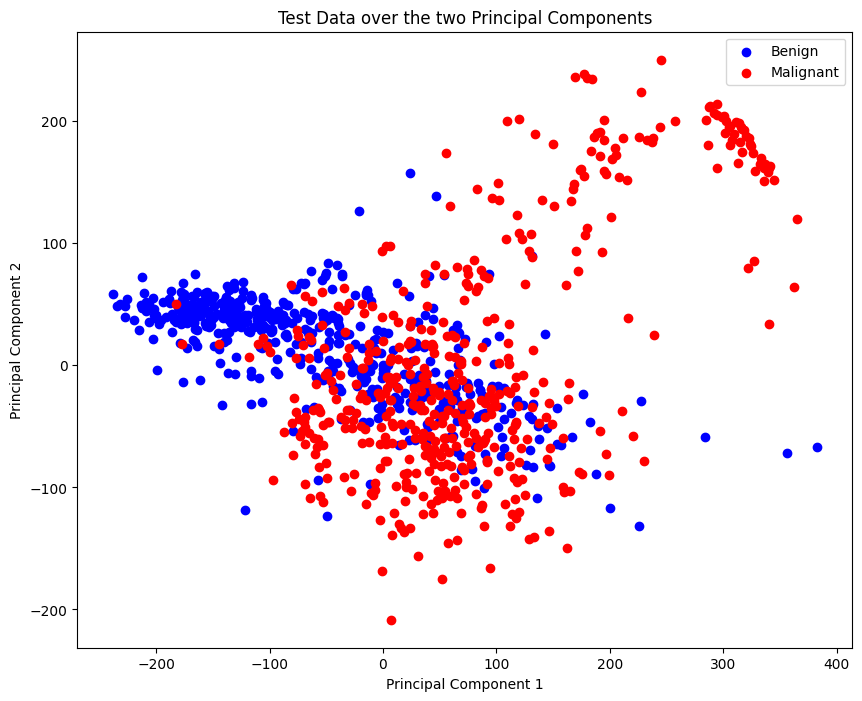

In [ ]:
# draw a scatter plot showing the classification of the test data
# we will only use the first 2 components for visualization

# Initialize the plot
plt.figure(figsize=(10, 8))

# Plot the benign class
plt.scatter(X_test_pca[y_test == 0, 0], X_test_pca[y_test == 0, 1], color='blue', label='Benign')

# Plot the malignant class
plt.scatter(X_test_pca[y_test == 1, 0], X_test_pca[y_test == 1, 1], color='red', label='Malignant')


# Add labels and title
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Test Data over the two Principal Components')
plt.legend()
plt.show()

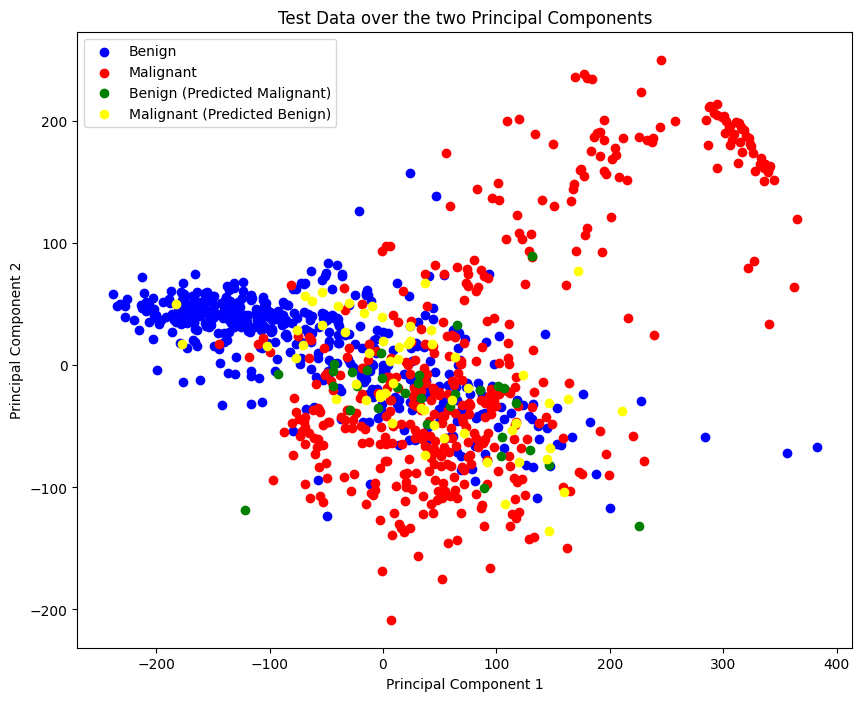

In [ ]:
# for comparison we will plot the svm's classification of the test data
# over the same plot.
# use different colors for beningned and predicted benign, malignant and predicted malignant, etc.

# Initialize the plot
plt.figure(figsize=(10, 8))

# Plot the correctly classified benign class
plt.scatter(X_test_pca[(y_test == 0) & (y_pred == 0), 0], X_test_pca[(y_test == 0) & (y_pred == 0), 1], color='blue', label='Benign')

# Plot the correctly classified malignant class
plt.scatter(X_test_pca[(y_test == 1) & (y_pred == 1), 0], X_test_pca[(y_test == 1) & (y_pred == 1), 1], color='red', label='Malignant')

# Plot the incorrectly classified benign class
plt.scatter(X_test_pca[(y_test == 0) & (y_pred == 1), 0], X_test_pca[(y_test == 0) & (y_pred == 1), 1], color='green', label='Benign (Predicted Malignant)')

# Plot the incorrectly classified malignant class
plt.scatter(X_test_pca[(y_test == 1) & (y_pred == 0), 0], X_test_pca[(y_test == 1) & (y_pred == 0), 1], color='yellow', label='Malignant (Predicted Benign)')

# Add labels and title
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Test Data over the two Principal Components')
plt.legend()
plt.show()

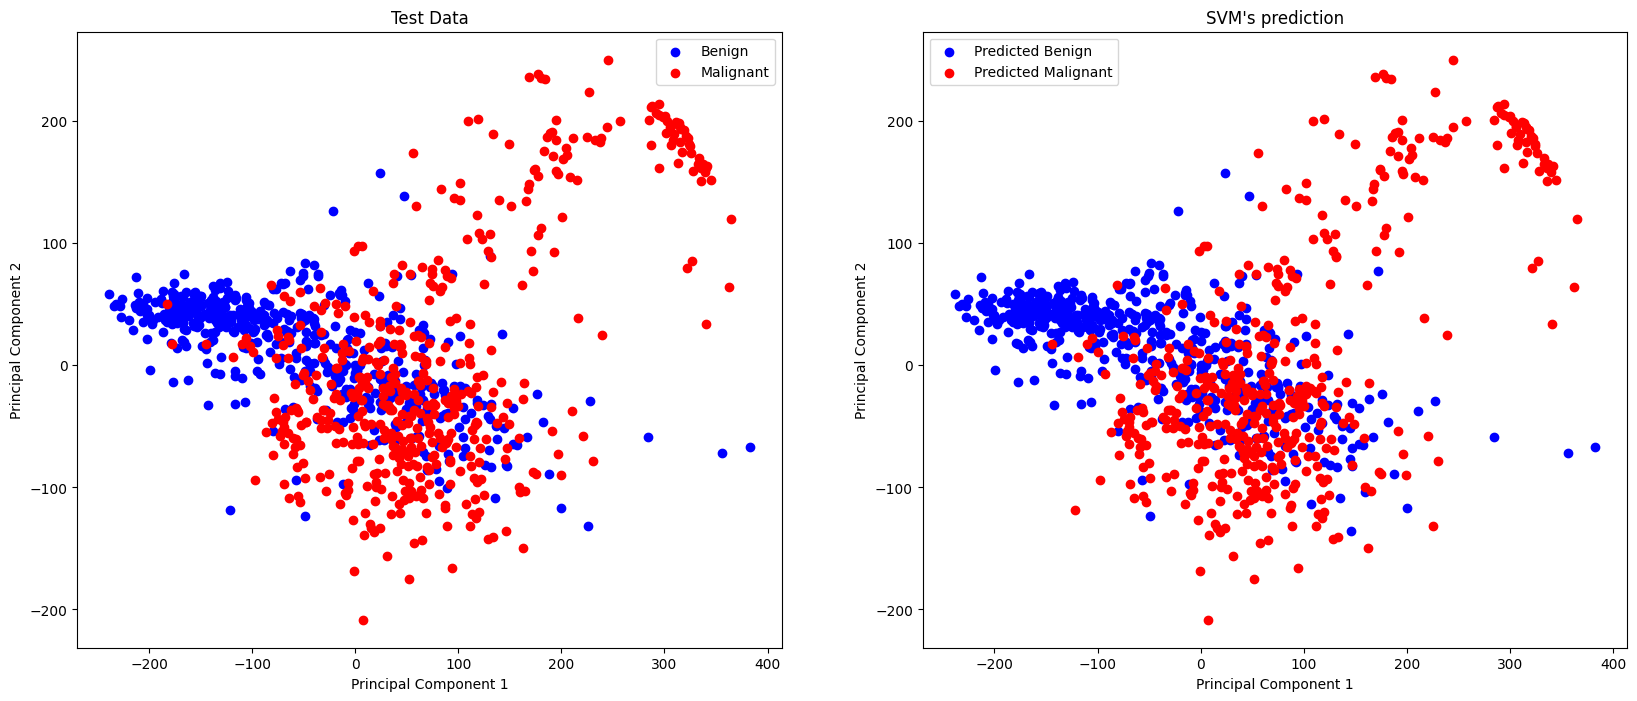

In [ ]:
# draw a side by side comparison of the classification of test data
# and the predicted test data

# Initialize the plot
plt.figure(figsize=(20, 8))

# Plot the test data
plt.subplot(1, 2, 1)
plt.scatter(X_test_pca[y_test == 0, 0], X_test_pca[y_test == 0, 1], color='blue', label='Benign')
plt.scatter(X_test_pca[y_test == 1, 0], X_test_pca[y_test == 1, 1], color='red', label='Malignant')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Test Data')
plt.legend()

# Plot the predicted test data
plt.subplot(1, 2, 2)
plt.scatter(X_test_pca[y_pred == 0, 0], X_test_pca[y_pred == 0, 1], color='blue', label='Predicted Benign')
plt.scatter(X_test_pca[y_pred == 1, 0], X_test_pca[y_pred == 1, 1], color='red', label='Predicted Malignant')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('SVM\'s prediction')
plt.legend()

plt.show()



## Logistic Regression

In [ ]:
# logistic regression
from sklearn.linear_model import LogisticRegression

# Initialize the model
logistic_model = LogisticRegression(max_iter=5000)

# Fit the model
logistic_model.fit(X_train_full_pca, y_train_full)


LogisticRegression(max_iter=5000)

In [ ]:
# predict on test data
y_pred = logistic_model.predict(X_test_pca)

In [ ]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print('Test Accuracy:', accuracy)
print(classification_report(y_test, y_pred))

Test Accuracy: 0.859
              precision    recall  f1-score   support

           0       0.86      0.86      0.86       500
           1       0.86      0.86      0.86       500

    accuracy                           0.86      1000
   macro avg       0.86      0.86      0.86      1000
weighted avg       0.86      0.86      0.86      1000



### Plotting

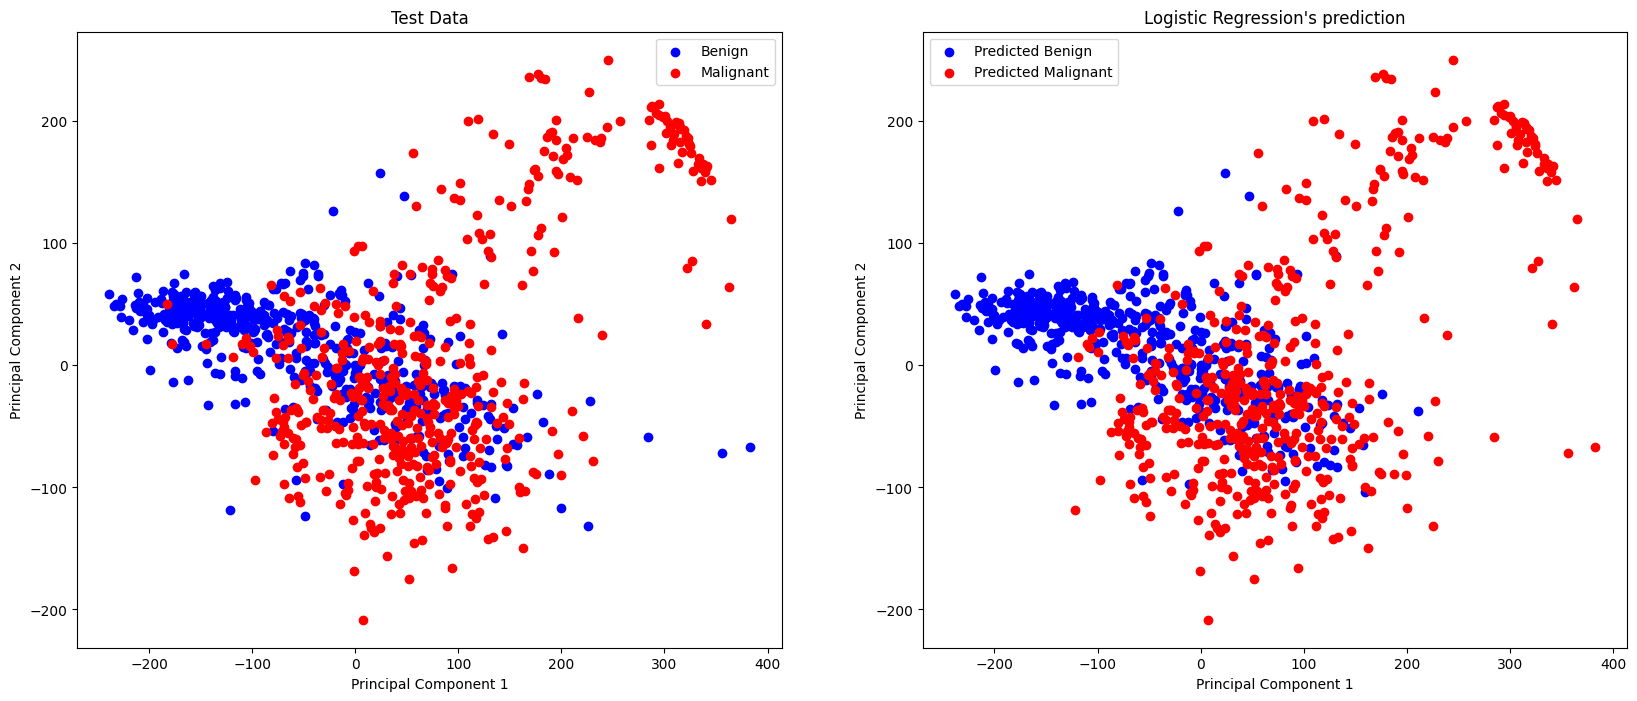

In [ ]:
# draw a side by side comparison of the classification of test data
# and the predicted test data

# Initialize the plot
plt.figure(figsize=(20, 8))

# Plot the test data
plt.subplot(1, 2, 1)
plt.scatter(X_test_pca[y_test == 0, 0], X_test_pca[y_test == 0, 1], color='blue', label='Benign')
plt.scatter(X_test_pca[y_test == 1, 0], X_test_pca[y_test == 1, 1], color='red', label='Malignant')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Test Data')
plt.legend()

# Plot the predicted test data
plt.subplot(1, 2, 2)
plt.scatter(X_test_pca[y_pred == 0, 0], X_test_pca[y_pred == 0, 1], color='blue', label='Predicted Benign')
plt.scatter(X_test_pca[y_pred == 1, 0], X_test_pca[y_pred == 1, 1], color='red', label='Predicted Malignant')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Logistic Regression\'s prediction')
plt.legend()

plt.show()

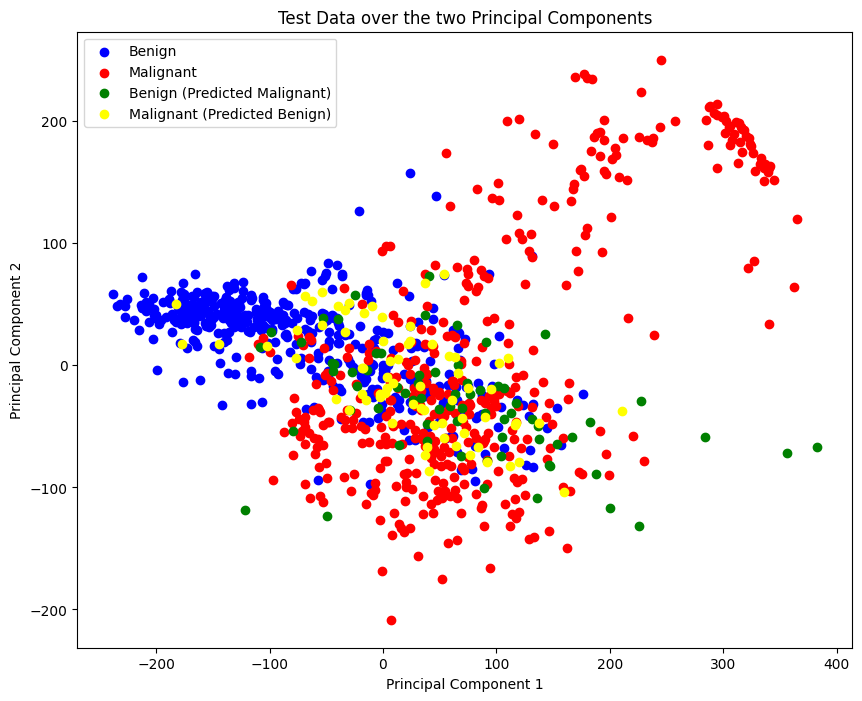

In [ ]:
# for comparison we will plot the svm's classification of the test data
# over the same plot.
# use different colors for beningned and predicted benign, malignant and predicted malignant, etc.

# Initialize the plot
plt.figure(figsize=(10, 8))

# Plot the correctly classified benign class
plt.scatter(X_test_pca[(y_test == 0) & (y_pred == 0), 0], X_test_pca[(y_test == 0) & (y_pred == 0), 1], color='blue', label='Benign')

# Plot the correctly classified malignant class
plt.scatter(X_test_pca[(y_test == 1) & (y_pred == 1), 0], X_test_pca[(y_test == 1) & (y_pred == 1), 1], color='red', label='Malignant')

# Plot the incorrectly classified benign class
plt.scatter(X_test_pca[(y_test == 0) & (y_pred == 1), 0], X_test_pca[(y_test == 0) & (y_pred == 1), 1], color='green', label='Benign (Predicted Malignant)')

# Plot the incorrectly classified malignant class
plt.scatter(X_test_pca[(y_test == 1) & (y_pred == 0), 0], X_test_pca[(y_test == 1) & (y_pred == 0), 1], color='yellow', label='Malignant (Predicted Benign)')

# Add labels and title
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Test Data over the two Principal Components')
plt.legend()
plt.show()

In [ ]:
# find decision boundary of the logistic regression model by PCA again to 2 components
# and then find the decision boundary

# Initialize PCA
two_d_pca = PCA(n_components=2)

# Fit and transform the data
X_train_full_pca_2d = two_d_pca.fit_transform(X_train_full_scaled)


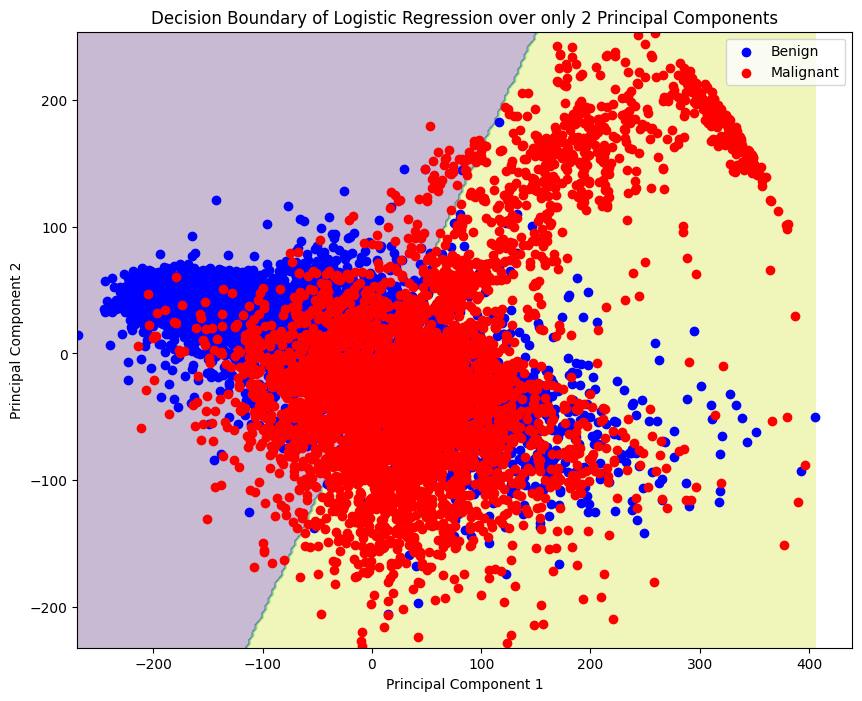

In [ ]:

# Initialize the model
two_d_logistic_model = LogisticRegression(max_iter=5000)

# Fit the model
two_d_logistic_model.fit(X_train_full_pca_2d, y_train_full)

# Plot the decision boundary
# Create a meshgrid
x_min, x_max = X_train_full_pca_2d[:, 0].min() - 1, X_train_full_pca_2d[:, 0].max() + 1
y_min, y_max = X_train_full_pca_2d[:, 1].min() - 1, X_train_full_pca_2d[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 3), np.arange(y_min, y_max,  3))

# Predict the labels
Z = two_d_logistic_model.predict(np.c_[xx.ravel(), yy.ravel()])

# Reshape the predictions
Z = Z.reshape(xx.shape)

# Plot the decision boundary
plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z, alpha=0.3)
plt.scatter(X_train_full_pca_2d[y_train_full == 0, 0], X_train_full_pca_2d[y_train_full == 0, 1], color='blue', label='Benign')

plt.scatter(X_train_full_pca_2d[y_train_full == 1, 0], X_train_full_pca_2d[y_train_full == 1, 1], color='red', label='Malignant')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Decision Boundary of Logistic Regression over only 2 Principal Components')
plt.legend()
plt.show()

In [ ]:
# plot the decision boundary of the best svm model
# Initialize the model
two_d_best_svm = SVC(kernel='rbf', C=C, gamma=gamma)

# Fit the model
two_d_best_svm.fit(X_train_full_pca_2d, y_train_full)


SVC(C=4.6415888336127775)

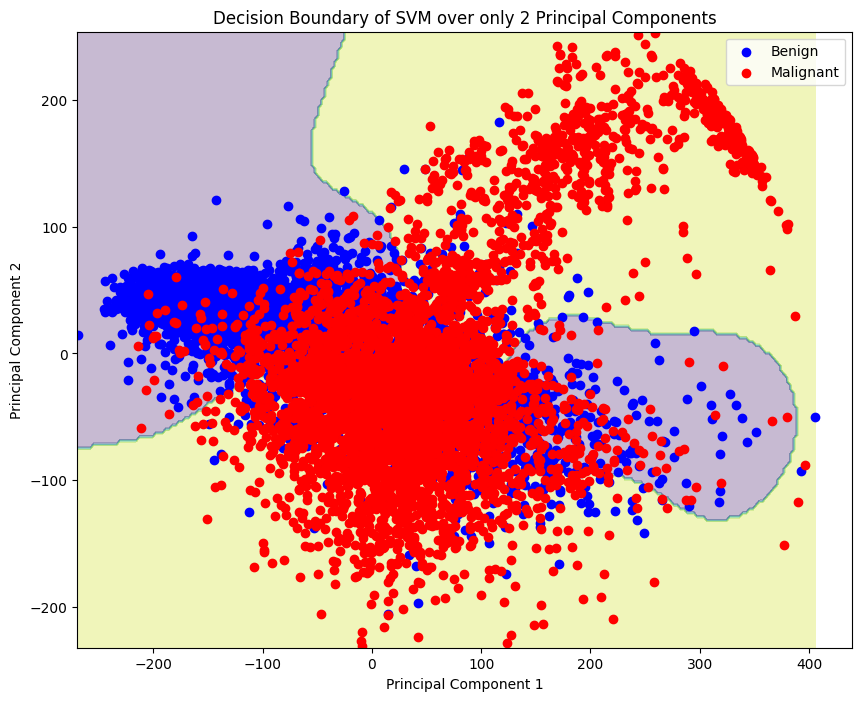

In [ ]:

# Plot the decision boundary
# Predict the labels
Z = two_d_best_svm.predict(np.c_[xx.ravel(), yy.ravel()])

# Reshape the predictions
Z = Z.reshape(xx.shape)

# Plot the decision boundary
plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z, alpha=0.3)
plt.scatter(X_train_full_pca_2d[y_train_full == 0, 0], X_train_full_pca_2d[y_train_full == 0, 1], color='blue', label='Benign')

plt.scatter(X_train_full_pca_2d[y_train_full == 1, 0], X_train_full_pca_2d[y_train_full == 1, 1], color='red', label='Malignant')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Decision Boundary of SVM over only 2 Principal Components')
plt.legend()
plt.show()